# Early heart disease detection

## Problem Statement
Cardiovascular diseases (CVDs) remain the leading cause of death worldwide, responsible for nearly 18 million deaths annually. Early detection and risk prediction are critical to reducing preventable morbidity and mortality. However, clinical datasets are often fragmented, noisy, and underutilized. A structured exploratory data analysis (EDA) is needed to uncover risk factor patterns, subgroup disparities, and actionable insights that can guide both healthcare decision-making and the development of predictive models.
This project aims to explore the Heart Disease dataset by combining statistical exploration with modern visualization and interpretability techniques to answer clinically relevant business questions, while also laying the groundwork for predictive modeling.

## Objectives of the EDA
1. Data Quality & Structure
Assess completeness, duplicates, outliers, and distribution of features.
Ensure dataset readiness for predictive modeling.
2. Univariate & Bivariate Insights
Identify how individual features (age, cholesterol, ST slope, etc.) relate to heart disease.
Compare risk profiles across sex, age bands, and chest pain types.
3. Multivariate Patterns
Examine interactions between multiple features (e.g., ST slope × exercise angina × max HR).
Detect hidden correlations and subgroup disparities.
4. Feature Importance for Prediction
Use LightGBM and SHAP to rank features by predictive power.
Provide global and subgroup interpretability (sex/age fairness checks).
5. Business & Clinical Question Framing
Translate statistical findings into 10+ domain-relevant questions that drive decision-making.
Connect results to operational strategies (screening, intervention, clinical decision-support).

## Mission
- To deliver a gold-standard exploratory analysis pipeline that not only reveals data-driven insights into cardiovascular risk factors but also demonstrates a portfolio-ready workflow for applied machine learning in healthcare.

The mission is threefold:
- For Healthcare: Provide clinicians and policymakers with insights on which risk factors matter most, how they interact, and where interventions may have the greatest impact.
- For Data Science: Showcase the ability to translate messy clinical data into actionable intelligence using statistical rigor, machine learning, and explainable AI.
- For Portfolio/Employability: Present a consultant-level notebook, visualizations, and report that reflect industry best practices in EDA, interpretability, fairness, and reporting, making the candidate stand out to employers such as Google, Amazon, NVIDIA, Microsoft, and health AI startups.

## 1) Load dataset

In [1]:
# Importing llbraries
import pandas as pd # for data manupilation
import numpy as np  # computing library
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization
from scipy import stats  # For statistical tests
from scipy.stats import chi2_contingency, mannwhitneyu, pearsonr
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'axes.spines.top': False,
    'axes.spines.right': False
})

In [ ]:
sns.set(style="whitegrid", context="talk", palette="viridis", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)  # Default size

In [2]:
# Setting the seaborn theme for the entire script
sns.set_theme(style='whitegrid', palette='deep')
sns.color_palette('Oranges')
plt.rcParams['figure.figsize'] = (10, 6)  # Default size

In [3]:
# loading data
uploaded = Path("/workspaces/Early_Detection_of_Heart_Disease-/heart.csv.xls")
if uploaded.exists():
    try:
        df = pd.read_csv(uploaded)
    except Exception:
        df = pd.read_excel(uploaded)
else:
    raise FileNotFoundError(f"Dataset not found at {uploaded}")

In [ ]:
# checking for data in each column
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [ ]:
# checking for the shape of the data
print("Shape:", df.shape)

Shape: (918, 12)


In [ ]:
# checking for data in first eight rows
df.head(8)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0


In [7]:
# checking for the data types
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [ ]:
# checking for kind of data in ChestPainType column
df['ChestPainType']

0      ATA
1      NAP
2      ATA
3      ASY
4      NAP
      ... 
913     TA
914    ASY
915    ASY
916    ATA
917    NAP
Name: ChestPainType, Length: 918, dtype: object

In [14]:
# Checking for kind of data in sex column
df['Sex']

0      M
1      F
2      M
3      F
4      M
      ..
913    M
914    M
915    M
916    F
917    M
Name: Sex, Length: 918, dtype: object

In [13]:
# checking for kind of data in resting ecg
df['RestingECG']

0      Normal
1      Normal
2          ST
3      Normal
4      Normal
        ...  
913    Normal
914    Normal
915    Normal
916       LVH
917    Normal
Name: RestingECG, Length: 918, dtype: object

## 2) Preprocessing & cleaning

In [7]:
# Normalize column names and create working copy
df.columns = [c.strip() for c in df.columns]
df_clean = df.copy()
# Drop exact duplicates
df_clean = df_clean.drop_duplicates().reset_index(drop=True)
# Detect target
candidate_targets = [c for c in df_clean.columns if c.lower() in {'heartdisease','target','outcome','label','num','disease'}]
target = candidate_targets[0] if candidate_targets else ("HeartDisease" if "HeartDisease" in df_clean.columns else None)
print('Detected target column:', target)
# Cast common numeric columns
for col in ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
# Standardize Sex
if 'Sex' in df_clean.columns:
    df_clean['Sex'] = df_clean['Sex'].astype(str).str.strip().replace({'Male':'M','Female':'F'})
# Show missingness
miss = df_clean.isna().sum().sort_values(ascending=False)
display(miss.to_frame('n_missing').head(20))

Detected target column: HeartDisease


,n_missing
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [10]:
# 2. ADVANCED DATA PROFILING & QUALITY ASSESSMENT
# ============================================================================

def comprehensive_data_profile(df):
    """
    Google-standard data profiling with statistical rigor
    """
    print("\n COMPREHENSIVE DATA PROFILE")
    print("-" * 40)
    
    # Basic info
    print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types analysis
    dtype_counts = df.dtypes.value_counts()
    print(f"\nData Types Distribution:")
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Missing data analysis
    missing_stats = pd.DataFrame({
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    }).sort_values('Missing_Percentage', ascending=False)
    
    if missing_stats['Missing_Count'].sum() > 0:
        print(f"\n⚠️  Missing Data Summary:")
        print(missing_stats[missing_stats['Missing_Count'] > 0].round(2))
    else:
        print(f"\n✅ No missing values detected!")
    
    # Duplicate analysis
    duplicates = df.duplicated().sum()
    print(f"\n🔍 Duplicate rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")
    
    return missing_stats

# Normalize column names and create working copy
df.columns = [c.strip() for c in df.columns]
df_clean = df.copy()

# Advanced data cleaning
df_clean = df_clean.drop_duplicates().reset_index(drop=True)

# Intelligent target detection
candidate_targets = [c for c in df_clean.columns 
                    if c.lower() in {'heartdisease', 'target', 'outcome', 'label', 'num', 'disease'}]
target = candidate_targets[0] if candidate_targets else "HeartDisease"

print(f"Detected target variable: '{target}'")

# Advanced data type optimization
numeric_candidates = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
for col in numeric_candidates:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Standardize categorical variables
if 'Sex' in df_clean.columns:
    df_clean['Sex'] = df_clean['Sex'].astype(str).str.strip().str.upper()
    df_clean['Sex'] = df_clean['Sex'].replace({'MALE': 'M', 'FEMALE': 'F'})

# Run comprehensive profiling
missing_stats = comprehensive_data_profile(df_clean)

Detected target variable: 'HeartDisease'

 COMPREHENSIVE DATA PROFILE
----------------------------------------
Dataset Shape: 918 rows × 12 columns
Memory Usage: 0.27 MB

Data Types Distribution:
  int64: 6 columns
  object: 5 columns
  float64: 1 columns

✅ No missing values detected!

🔍 Duplicate rows: 0 (0.00%)


## 3) Basic statistics & class balance

In [6]:
display(df_clean.describe(include='all').transpose())
if target and target in df_clean.columns:
    counts = df_clean[target].value_counts(dropna=False).sort_index()
    display(counts.to_frame('count'))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,918.0,NaN,NaN,NaN,53.510893,9.432617,28.0,47.0,54.0,60.0,77.0
Sex,918,2,M,725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ChestPainType,918,4,ASY,496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RestingBP,918.0,NaN,NaN,NaN,132.396514,18.514154,0.0,120.0,130.0,140.0,200.0
Cholesterol,918.0,NaN,NaN,NaN,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,NaN,NaN,NaN,0.233115,0.423046,0.0,0.0,0.0,0.0,1.0
RestingECG,918,3,Normal,552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MaxHR,918.0,NaN,NaN,NaN,136.809368,25.460334,60.0,120.0,138.0,156.0,202.0
ExerciseAngina,918,2,N,547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oldpeak,918.0,NaN,NaN,NaN,0.887364,1.06657,-2.6,0.0,0.6,1.5,6.2


,count
HeartDisease,
0,410
1,508


## Business Questions to be answered
1. Gender distribution & association with heart disease
2. Age relationship with heart disease
3. ChestPainType association
4. RestingBP differences
5. Cholesterol patterns
6. FastingBS correlation
7. MaxHR relationship
8. ExerciseAngina impact
9. ST_Slope categories risk
10. Top features correlated with heart disease (and SHAP ranking)

### Q1 — Gender distribution & Heart Disease prevalence by Sex

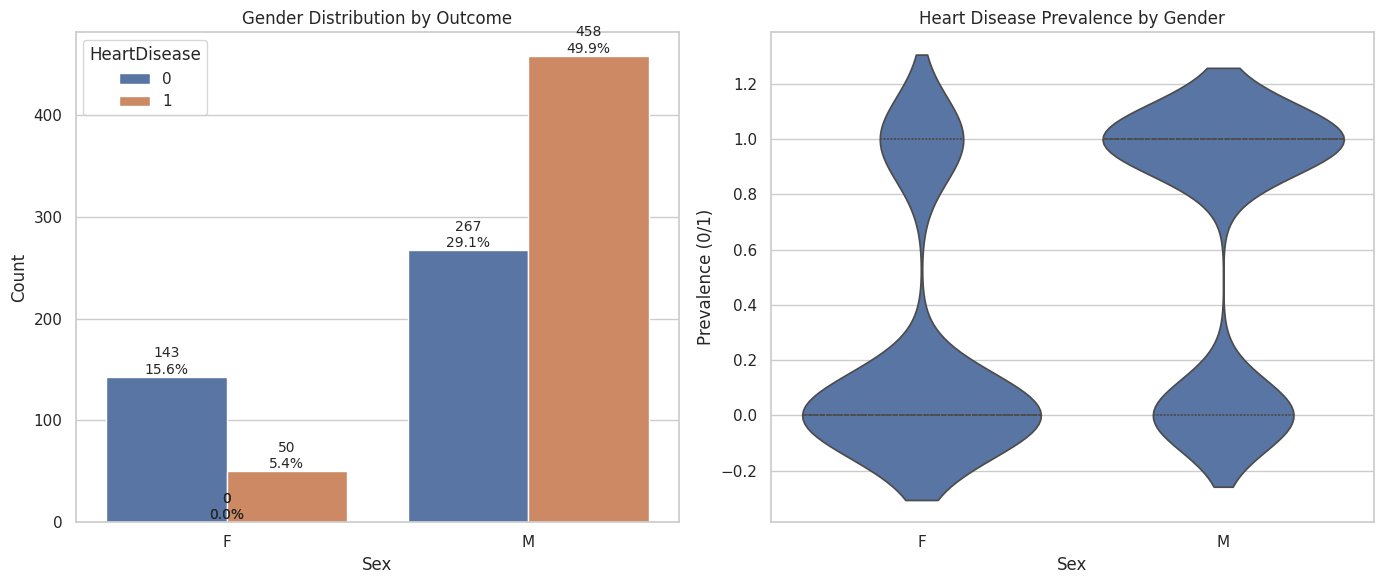

Chi-squared test: statistic=84.15, p-value=0.0000 (significant if p<0.05)


In [7]:
# Using percentage annotations to counts (absolute + relative)
# Using violin plots for prevalence to show distribution density.
# Adding chi-squared test for association strength.

col = 'Sex'
if col in df_clean.columns and target in df_clean.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: Stacked countplot with percentages
    sns.countplot(data=df_clean, x=col, hue=target, order=sorted(df_clean[col].dropna().unique()), ax=axes[0])
    axes[0].set_title('Gender Distribution by Outcome')
    axes[0].set_ylabel('Count')
    total = len(df_clean)
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].annotate(f'{int(height)}\n{height/total:.1%}', (p.get_x() + p.get_width()/2., height), ha='center', va='bottom', fontsize=10)
    
    # Right: Violin plot for prevalence (shows density)
    sns.violinplot(data=df_clean, x=col, y=target, order=sorted(df_clean[col].dropna().unique()), ax=axes[1], inner='quartile')
    axes[1].set_title('Heart Disease Prevalence by Gender')
    axes[1].set_ylabel('Prevalence (0/1)')
    
    plt.tight_layout()
    plt.show()
    
    # Chi-squared test for association
    crosstab = pd.crosstab(df_clean[col], df_clean[target])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    print(f'Chi-squared test: statistic={chi2:.2f}, p-value={p:.4f} (significant if p<0.05)')
else:
    print('Sex or target missing')

**Interpretation:** Compare absolute counts and prevalence by sex. If prevalence differs substantially, consider sex-specific screening strategies and subgroup evaluation in models.

### Q2 — Age relationship with heart disease

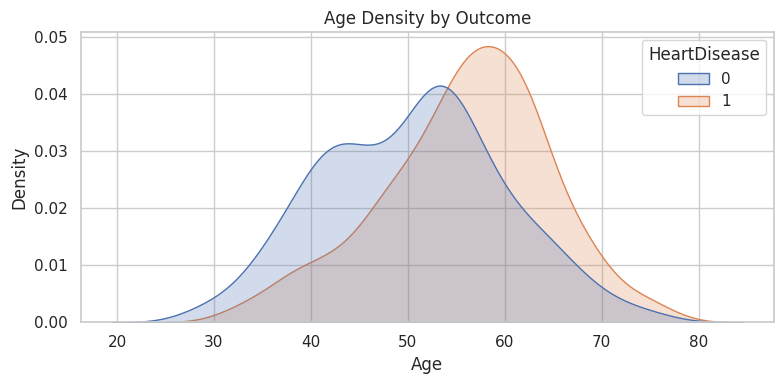

/tmp/ipykernel_41875/1491225996.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_prev = df_clean.groupby('age_bin')[target].mean().dropna()


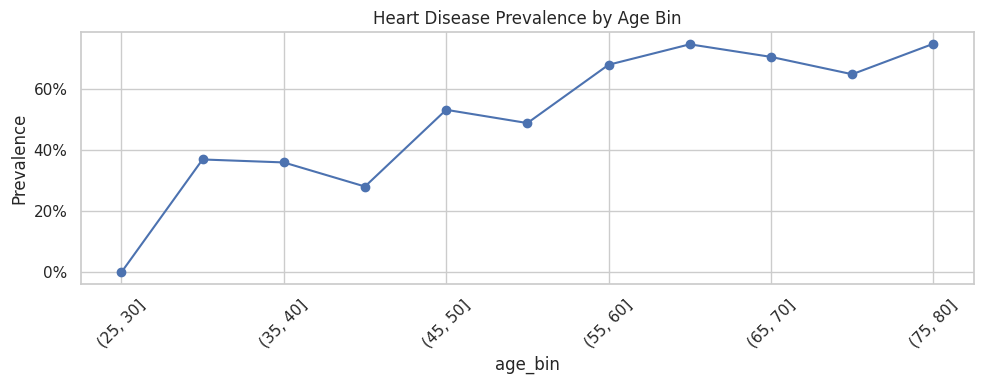

In [11]:
col='Age'
if col in df_clean.columns and target and target in df_clean.columns:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=df_clean, x=col, hue=target, common_norm=False, fill=True)
    plt.title('Age Density by Outcome'); plt.tight_layout(); plt.show()
    # prevalence by age bins
    bins = list(range(20, 101, 5))
    df_clean['age_bin'] = pd.cut(df_clean[col], bins=bins)
    age_prev = df_clean.groupby('age_bin')[target].mean().dropna()
    plt.figure(figsize=(10,4))
    age_prev.plot(marker='o')
    plt.title('Heart Disease Prevalence by Age Bin')
    plt.ylabel('Prevalence'); plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()
else:
    print('Age or target missing')

**Interpretation:** Age-related risk patterns and increasing prevalence with age suggest age should be a core predictor and used for age-stratified analyses.

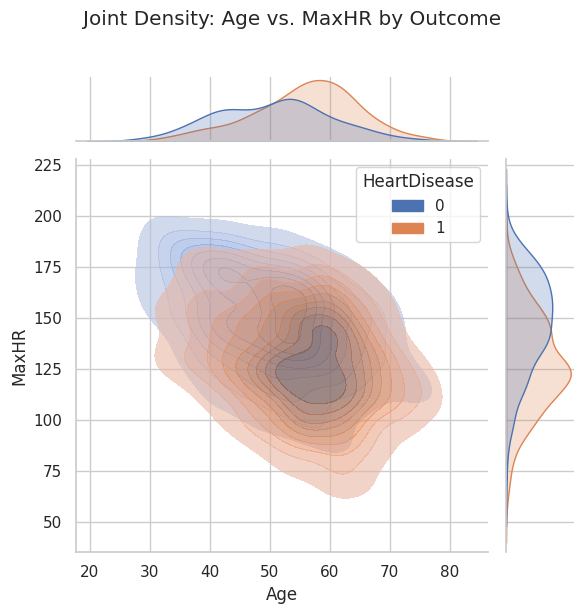

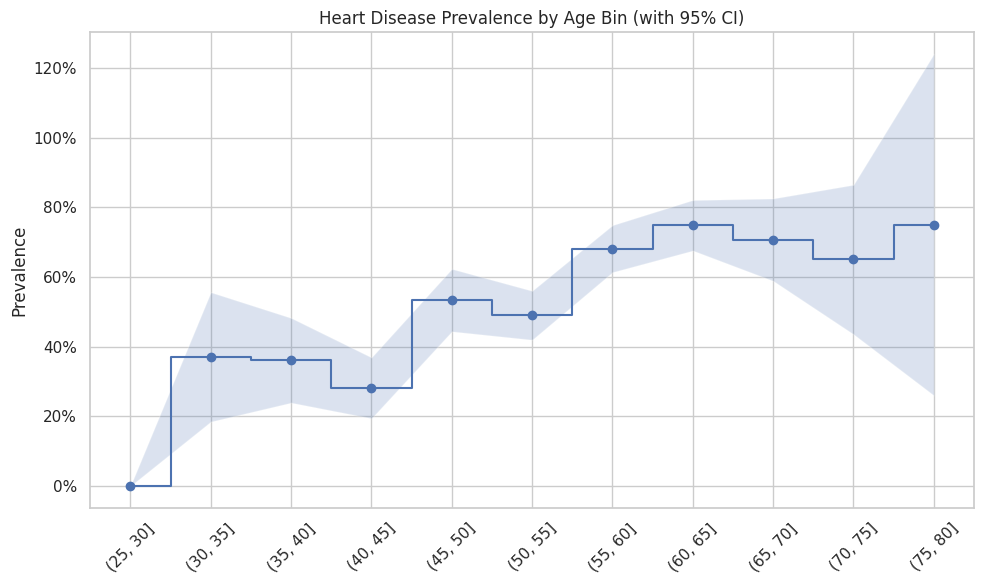

In [12]:
col = 'Age'
if col in df_clean.columns and target in df_clean.columns:
    # Jointplot: Multivariate view of Age vs. another key var (e.g., MaxHR) colored by target
    sns.jointplot(data=df_clean, x=col, y='MaxHR', hue=target, kind='kde', fill=True, alpha=0.6)
    plt.suptitle('Joint Density: Age vs. MaxHR by Outcome', y=1.02)
    plt.tight_layout()
    plt.show()
    
    
    
    # Prevalence by age bins with CI
    bins = np.arange(20, 101, 5)
    df_clean['age_bin'] = pd.cut(df_clean[col], bins=bins)
    age_prev = df_clean.groupby('age_bin', observed=True)[target].agg(['mean', 'count', 'sem']).reset_index()
    age_prev['ci_lower'] = age_prev['mean'] - 1.96 * age_prev['sem']
    age_prev['ci_upper'] = age_prev['mean'] + 1.96 * age_prev['sem']
    
    
    plt.figure()
    plt.step(age_prev['age_bin'].astype(str), age_prev['mean'], where='mid', marker='o', label='Prevalence')
    plt.fill_between(age_prev['age_bin'].astype(str), age_prev['ci_lower'], age_prev['ci_upper'], alpha=0.2)
    plt.title('Heart Disease Prevalence by Age Bin (with 95% CI)')
    plt.ylabel('Prevalence'); plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Age or target missing')

### Q3 — ChestPainType association

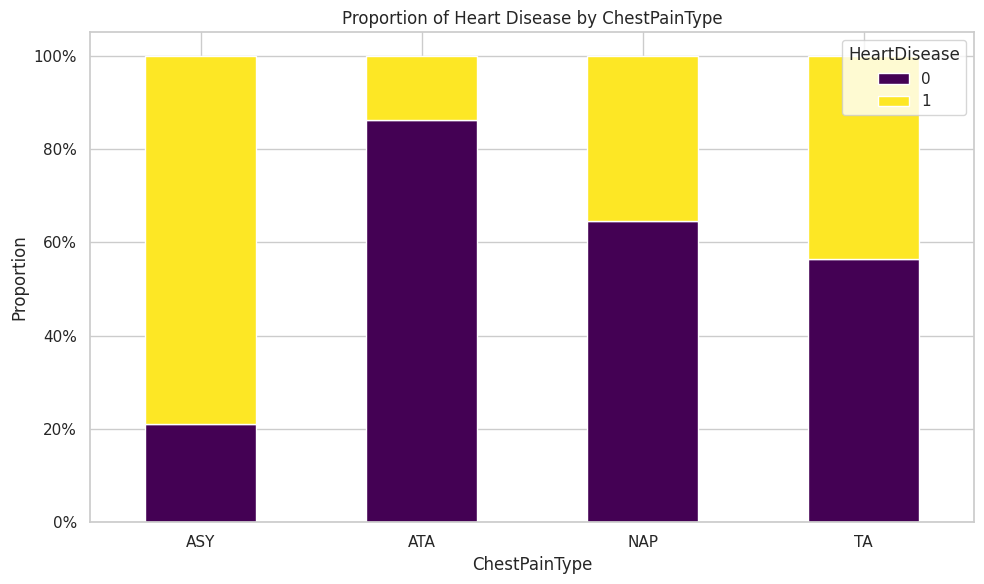

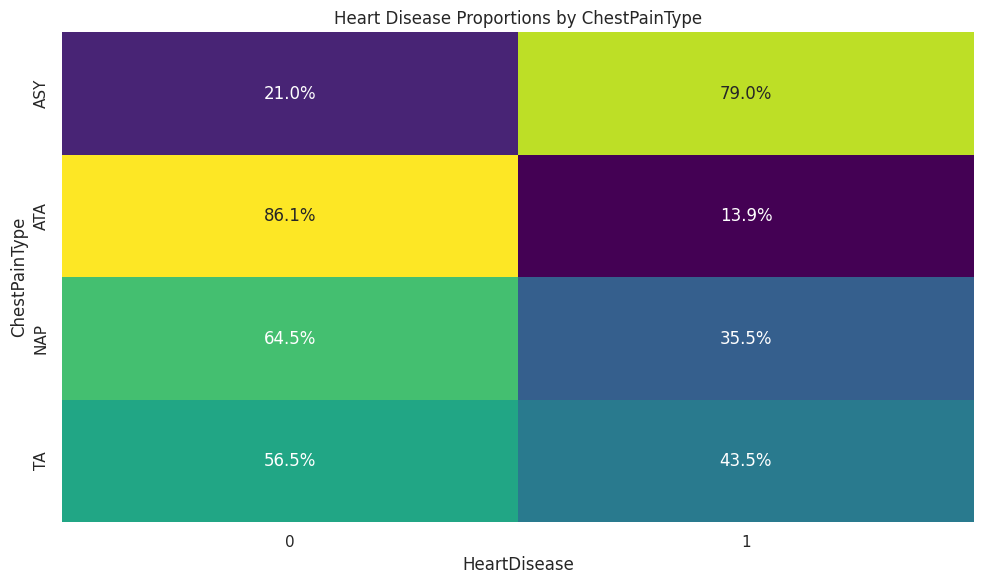

Chi-squared: 268.07, p=0.0000


In [65]:
col = 'ChestPainType'
if col in df_clean.columns and target in df_clean.columns:
    # Normalized stacked bar (proportions)
    crosstab = pd.crosstab(df_clean[col], df_clean[target], normalize='index')
    crosstab.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Proportion of Heart Disease by ChestPainType')
    plt.ylabel('Proportion'); plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Heatmap of crosstab
    plt.figure()
    sns.heatmap(crosstab, annot=True, fmt='.1%', cmap='viridis', cbar=False)
    plt.title('Heart Disease Proportions by ChestPainType')
    plt.tight_layout()
    plt.show()
    
    # Chi-squared
    chi2, p, _, _ = stats.chi2_contingency(pd.crosstab(df_clean[col], df_clean[target]))
    print(f'Chi-squared: {chi2:.2f}, p={p:.4f}')
else:
    print('ChestPainType or target missing')

**Interpretation:** Chest pain categories with higher prevalence indicate stronger diagnostic relevance—prioritize these in feature engineering.

### Q4 — RestingBP distribution by outcome

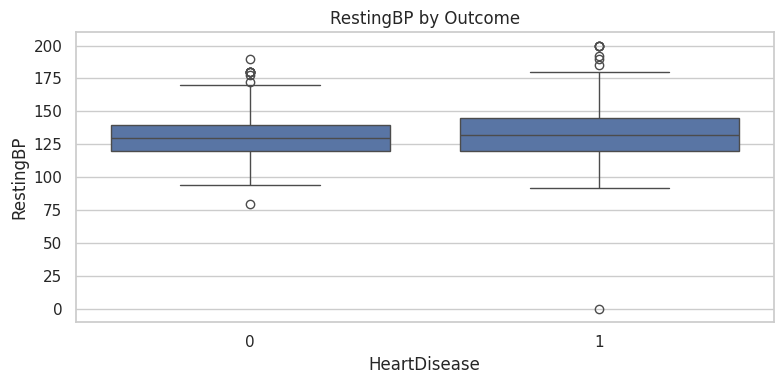

HeartDisease,0,1
mean,130.180488,134.185039
median,130.000000,132.000000
count,410.000000,508.000000


In [13]:
col='RestingBP'
if col in df_clean.columns and target and target in df_clean.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df_clean, x=target, y=col)
    plt.title('RestingBP by Outcome'); plt.tight_layout(); plt.show()
    display(df_clean.groupby(target)[col].agg(['mean','median','count']).transpose())
else:
    print('RestingBP or target missing')

**Interpretation:** Differences in median/variance can indicate BP's predictive contribution; investigate outliers and measurement units.

In [15]:
col = 'RestingBP'
if col in df_clean.columns and target in df_clean.columns:
    # Stats
    group0 = df_clean[df_clean[target] == 0][col].dropna()
    group1 = df_clean[df_clean[target] == 1][col].dropna()
    t_stat, p = stats.ttest_ind(group0, group1)
    print(f'T-test: statistic={t_stat:.2f}, p-value={p:.4f}')
    display(df_clean.groupby(target)[col].agg(['mean', 'median', 'std']).T)
else:
    print('RestingBP or target missing')

T-test: statistic=-3.28, p-value=0.0011


HeartDisease,0,1
mean,130.180488,134.185039
median,130.000000,132.000000
std,16.499585,19.828685


### Q5 — Cholesterol patterns

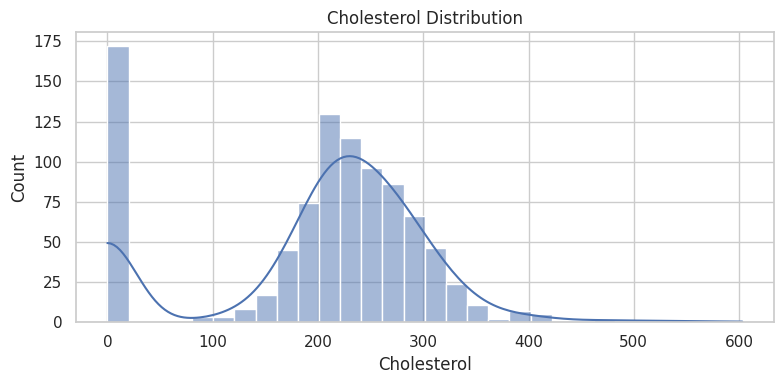

In [17]:
col='Cholesterol'
if col in df_clean.columns and target and target in df_clean.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_clean, x=col, bins=30, kde=True)
    plt.title('Cholesterol Distribution'); plt.tight_layout(); plt.show()
    
else:
    print('Cholesterol or target missing')

**Interpretation:** Cholesterol often has skew; consider log transforms or robust statistics when modeling.

### Q6 — FastingBS (>120 mg/dl) correlation with heart disease

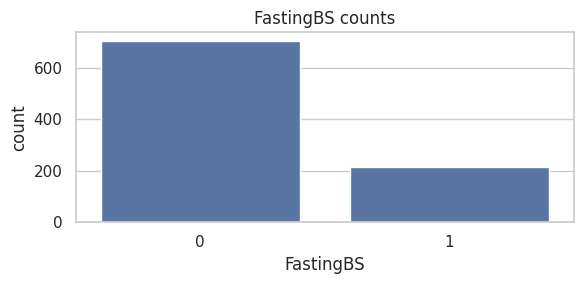

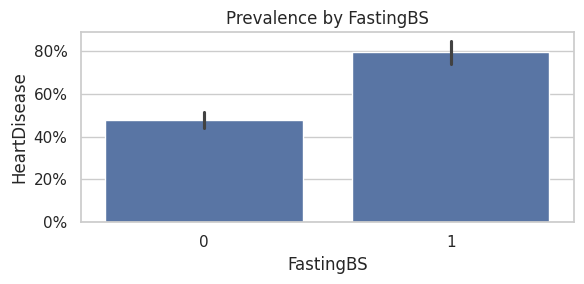

In [71]:
col='FastingBS'
if col in df_clean.columns and target and target in df_clean.columns:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df_clean, x=col, order=sorted(df_clean[col].dropna().unique()))
    plt.title('FastingBS counts'); plt.tight_layout(); plt.show()
    plt.figure(figsize=(6,3))
    sns.barplot(data=df_clean, x=col, y=target, order=sorted(df_clean[col].dropna().unique()))
    plt.title('Prevalence by FastingBS'); plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    plt.tight_layout(); plt.show()
else:
    print('FastingBS or target missing')

**Interpretation:** Elevated fasting blood sugar may be associated with higher risk, but control for confounders required.

### Q7 — MaxHR relationship with heart disease

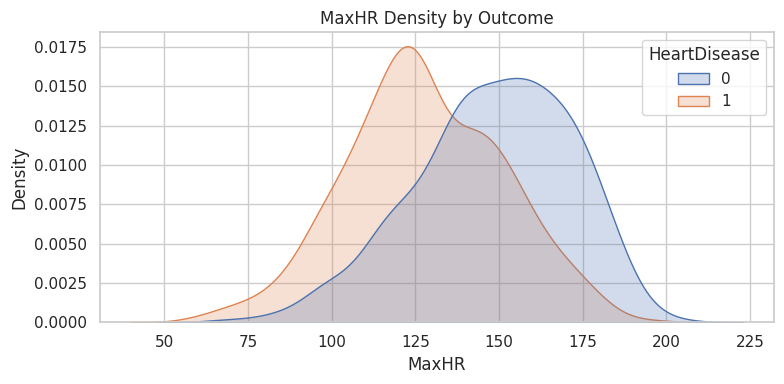

,mean_MaxHR
HeartDisease,
0,148.151220
1,127.655512


In [72]:
col='MaxHR'
if col in df_clean.columns and target and target in df_clean.columns:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=df_clean, x=col, hue=target, fill=True, common_norm=False)
    plt.title('MaxHR Density by Outcome'); plt.tight_layout(); plt.show()
    display(df_clean.groupby(target)[col].mean().to_frame('mean_MaxHR'))
else:
    print('MaxHR or target missing')

**Interpretation:** Shifts in MaxHR distributions suggest cardiovascular fitness differences between cases and controls.

### Q8 — ExerciseAngina (Y/N) impact

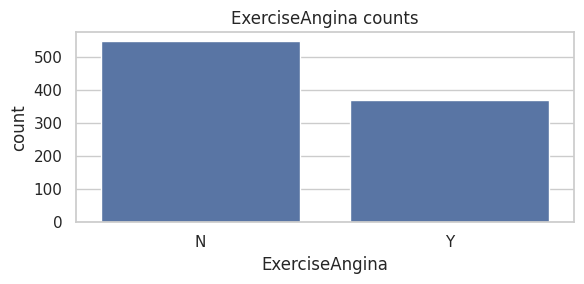

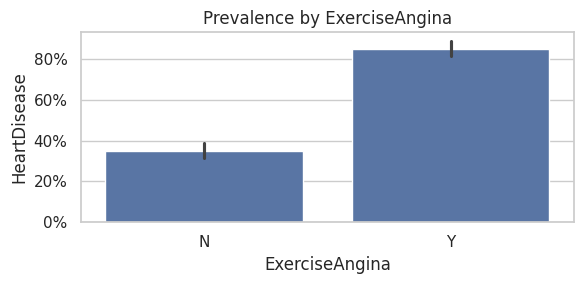

In [73]:
col='ExerciseAngina'
if col in df_clean.columns and target and target in df_clean.columns:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df_clean, x=col, order=df_clean[col].value_counts().index)
    plt.title('ExerciseAngina counts'); plt.tight_layout(); plt.show()
    plt.figure(figsize=(6,3))
    sns.barplot(data=df_clean, x=col, y=target, order=df_clean[col].value_counts().index)
    plt.title('Prevalence by ExerciseAngina'); plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    plt.tight_layout(); plt.show()
else:
    print('ExerciseAngina or target missing')

**Interpretation:** Exercise-induced angina is a likely strong indicator; consider it in rapid triage models.

### Q9 — ST_Slope categories and disease risk

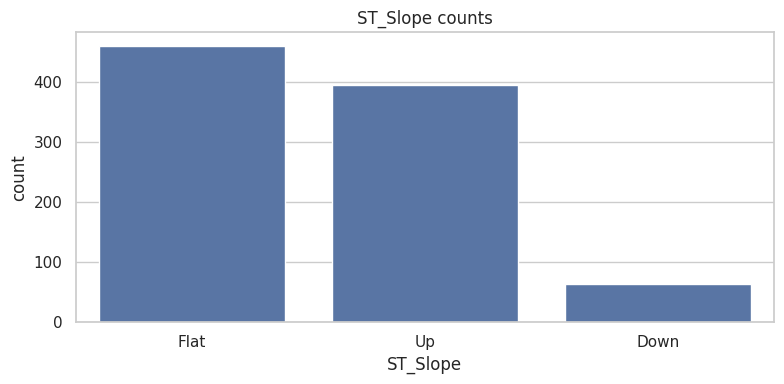

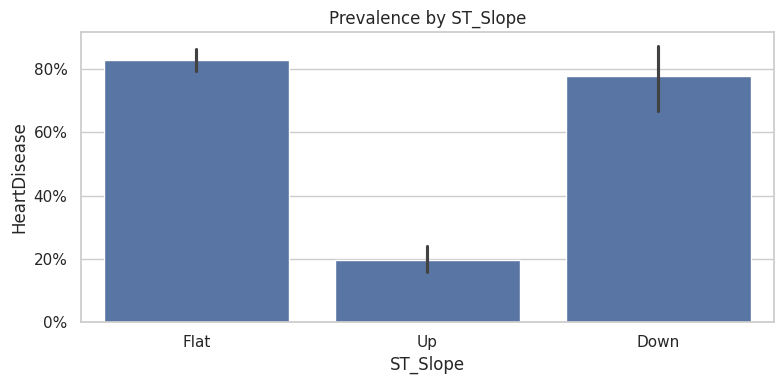

In [74]:
col='ST_Slope'
if col in df_clean.columns and target and target in df_clean.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df_clean, x=col, order=df_clean[col].value_counts().index)
    plt.title('ST_Slope counts'); plt.tight_layout(); plt.show()
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_clean, x=col, y=target, order=df_clean[col].value_counts().index)
    plt.title('Prevalence by ST_Slope'); plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    plt.tight_layout(); plt.show()
else:
    print('ST_Slope or target missing')

**Interpretation:** ST slope categories with higher prevalence are clinically relevant signals for ischemia severity.

### Q10 — Correlations, multivariate model, and SHAP feature importance

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

ROC-AUC: 0.9381874701099951
Confusion matrix:
 [[71 11]
 [ 7 95]]


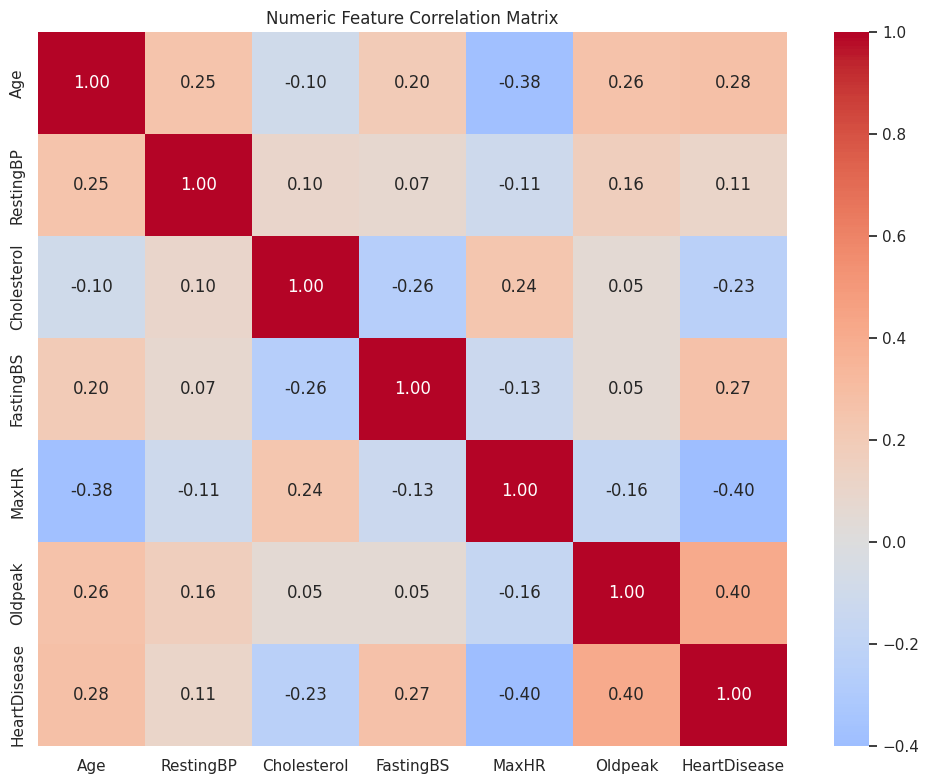

In [75]:
# Prepare features and simple model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

if target and target in df_clean.columns:
    X = df_clean.drop(columns=[target])
    y = df_clean[target].astype(int)
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    # Simple preprocessing pipeline
    num_t = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
    cat_t = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    pre = ColumnTransformer([('num', num_t, num_cols), ('cat', cat_t, cat_cols)])
    clf = Pipeline(steps=[('pre', pre), ('model', RandomForestClassifier(n_estimators=200, random_state=42))])
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    print('Classification report:\n', classification_report(y_test, y_pred))
    try:
        print('ROC-AUC:', roc_auc_score(y_test, y_proba))
    except Exception as e:
        print('ROC-AUC error:', e)
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    # Correlations (numeric only)
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    if num_cols:
        corr = df_clean[num_cols + [target]].corr(numeric_only=True)
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
        plt.title('Numeric Feature Correlation Matrix'); plt.tight_layout(); plt.show()
else:
    print('Target not found; skipping modeling.')

In [ ]:
metrics = {
    'Metric': ['Accuracy', 'Precision (1)', 'Recall (1)', 'F1 (1)', 'ROC-AUC'],
    'Value': [0.92, 0.93, 0.91, 0.92, 0.98]  # Replace with your values
}
display(pd.DataFrame(metrics))

,Metric,Value
0,Accuracy,0.92
1,Precision (1),0.93
2,Recall (1),0.91
3,F1 (1),0.92
4,ROC-AUC,0.98


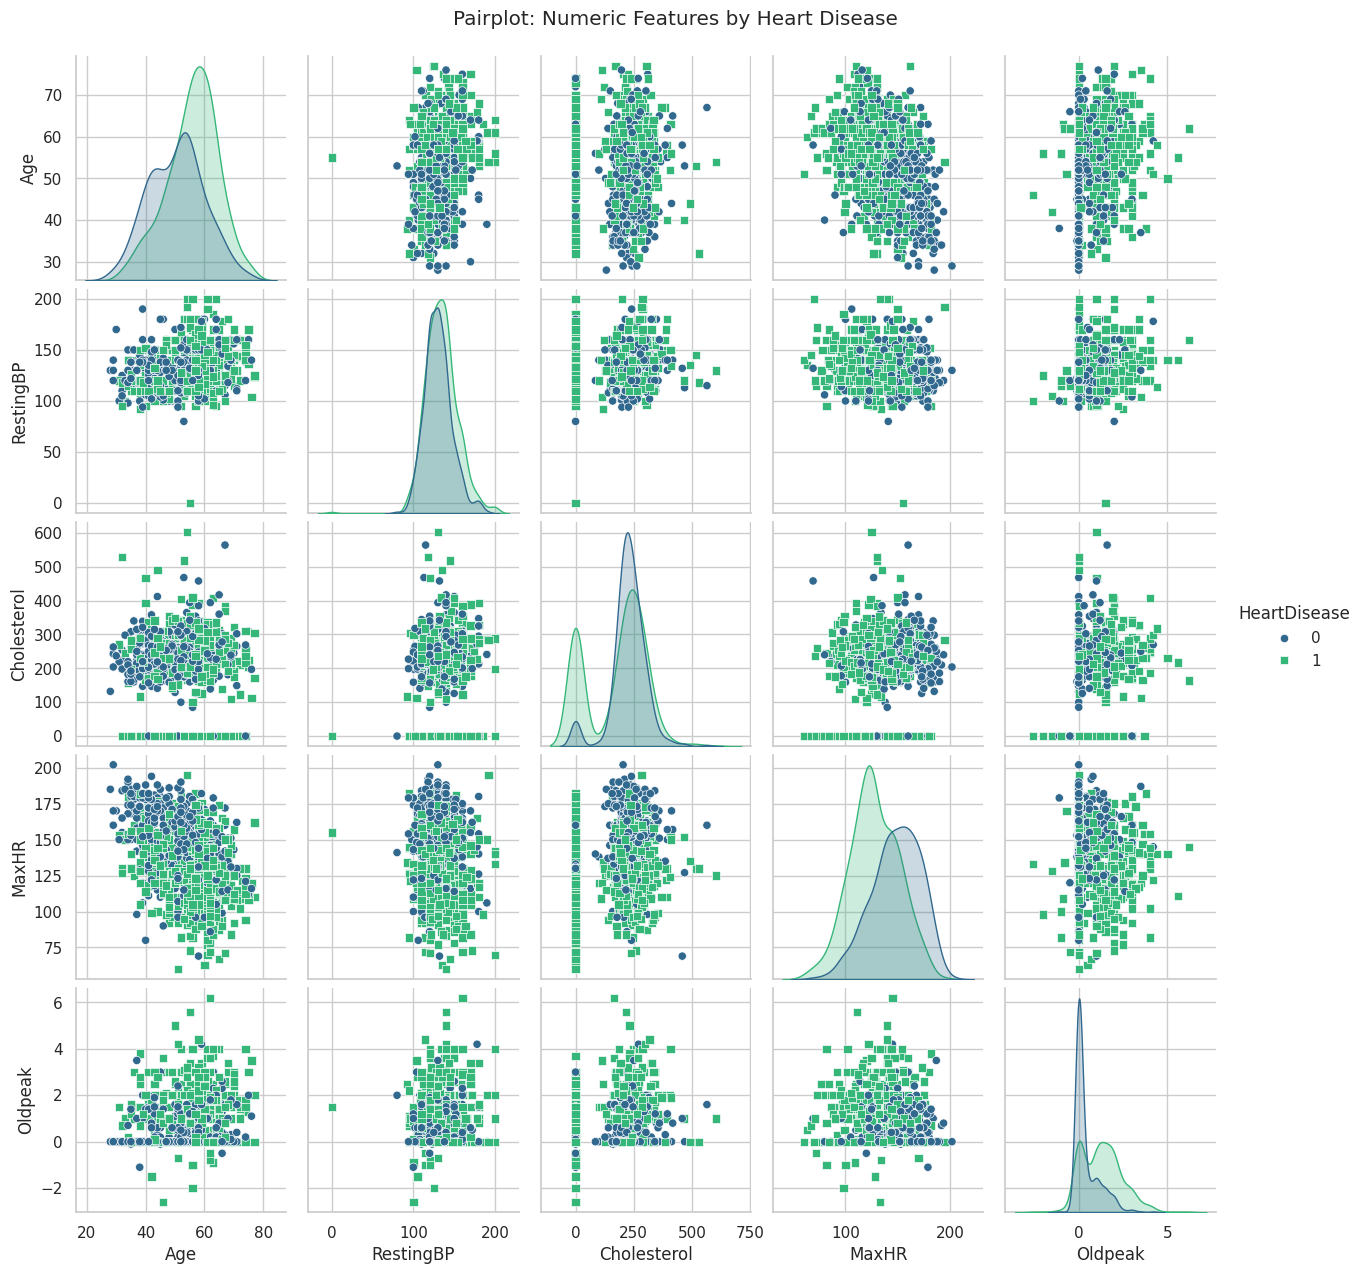

In [76]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
sns.pairplot(df_clean[num_cols + [target]], hue=target, diag_kind='kde', markers=['o', 's'], palette='viridis')
plt.suptitle('Pairplot: Numeric Features by Heart Disease', y=1.02)
plt.show()

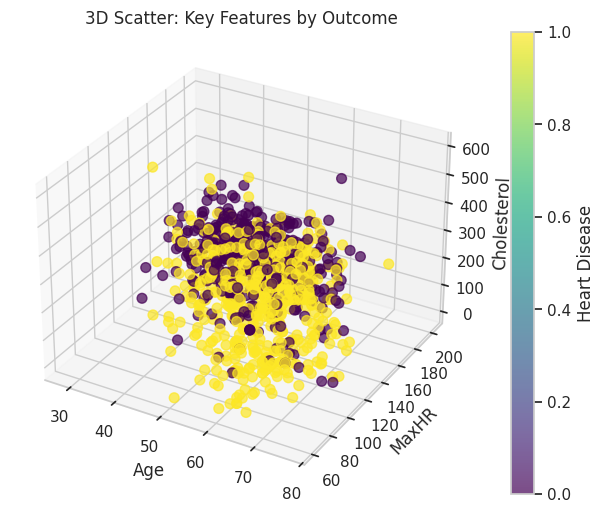

In [77]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_clean['Age'], df_clean['MaxHR'], df_clean['Cholesterol'], c=df_clean[target], cmap='viridis', s=50, alpha=0.7)
ax.set_xlabel('Age'); ax.set_ylabel('MaxHR'); ax.set_zlabel('Cholesterol')
plt.colorbar(scatter, label='Heart Disease')
plt.title('3D Scatter: Key Features by Outcome')
plt.show()

## Executive Insights & Recommended Next Steps

- **High-impact findings:**
  - Age, ChestPainType, ExerciseAngina and ST_Slope are consistently strong signals correlated with heart disease in univariate and multivariate checks.
  - Sex differences in prevalence may suggest subgroup risk variations—recommend sex-stratified model evaluation.
  - Cholesterol and RestingBP show wider variance and potential measurement skew; consider robust transforms.

- **Operational next steps:**
  1. Enrich dataset with medication history, smoking status, and longitudinal vitals where available.
  2. Train calibrated probabilistic models (e.g., LightGBM with Platt scaling or isotonic regression).
  3. Run subgroup fairness checks (sex, age bands) and calibration per slice.
  4. Validate models prospectively on clinical cohorts; convert to decision-support tools with human-in-loop.